## NetworkX Interface

NetworkX is a Python package for creating, manipulating, and studying the structure of complex networks (graphs).
It can be used to iterate over molecules, build topologies, or analyze molecular graphs.
You can find more information at https://networkx.org/documentation/stable/index.html

In [1]:
import networkx as nx
from IPython.display import display
from rdkit.Chem import Draw

import rdkit2ase

Let's create a simple molecule - `serotonin` - and analyze its number of bonds and cycles using NetworkX.

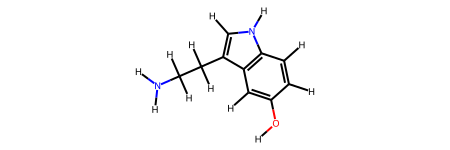

In [2]:
serotonin = rdkit2ase.smiles2atoms("C1=CC2=C(C=C1O)C(=CN2)CCN")
mol = rdkit2ase.ase2rdkit(serotonin)
display(mol)

Number of atoms: 25
Number of bonds: 26
Cycle 0 with atoms: [3, 2, 9, 8, 7]


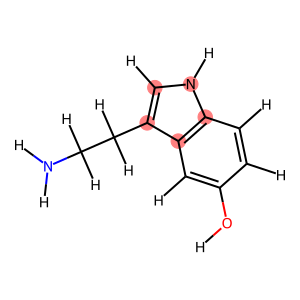

Cycle 1 with atoms: [3, 4, 5, 0, 1, 2]


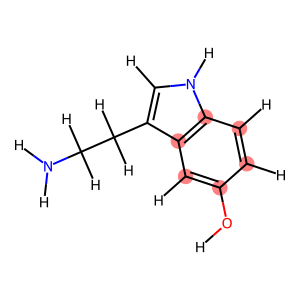

In [3]:
graph = rdkit2ase.ase2networkx(serotonin)
print(f"Number of atoms: {graph.number_of_nodes()}")
print(f"Number of bonds: {graph.number_of_edges()}")
for idx, cycle in enumerate(nx.cycle_basis(graph)):
    print(f"Cycle {idx} with atoms: {cycle}")
    display(Draw.MolToImage(mol, highlightAtoms=cycle))

The usage is not limited to single molecules but can also be applied to multi-molecule systems.

In [4]:
water = rdkit2ase.smiles2conformers("O", numConfs=10)
etoh = rdkit2ase.smiles2conformers("CCO", numConfs=10)
box = rdkit2ase.pack(
    data=[water, etoh], counts=[5, 5], density=800, packmol="packmol.jl"
)

In [5]:
graph = rdkit2ase.ase2networkx(box)
print(f"Graph with {len(graph)} atoms and {len(graph.edges())} bonds.")

Graph with 60 atoms and 50 bonds.


In [6]:
molecules = len(list(nx.connected_components(graph)))
print(f"Found {molecules} molecules")

Found 10 molecules


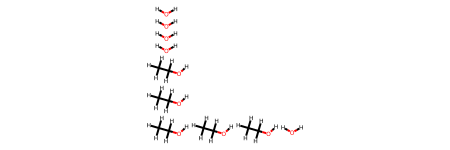

In [7]:
rdkit2ase.networkx2rdkit(graph)

The graph can also be converted back to an ASE Atoms object, keeping most properties.

In [8]:
rdkit2ase.networkx2ase(graph)

Atoms(symbols='OH2OH2OH2OH2OH2C2OH6C2OH6C2OH6C2OH6C2OH6', pbc=True, cell=[8.728901107040366, 8.728901107040366, 8.728901107040366], initial_charges=...)